In [64]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

In [66]:
# 1. Fetch ASX200 data from Yahoo Finance
print("Fetching ASX200 data from Yahoo Finance...")
data = yf.download('^AXJO', start='2020-01-01', end='2025-01-01')
print(f"Data fetched successfully. Shape: {data.shape}")

# Display the first few rows
data.head()

[*********************100%***********************]  1 of 1 completed

Fetching ASX200 data from Yahoo Finance...
Data fetched successfully. Shape: (1266, 5)


Price,Close,High,Low,Open,Volume
Ticker,^AXJO,^AXJO,^AXJO,^AXJO,^AXJO
Date,,,,,
2020-01-02,6690.600098,6709.200195,6669.200195,6684.100098,304900
2020-01-03,6733.500000,6788.200195,6690.600098,6690.600098,365200
2020-01-06,6735.700195,6738.600098,6671.700195,6733.100098,469800
2020-01-07,6826.399902,6834.299805,6735.700195,6735.700195,447400
2020-01-08,6817.600098,6831.700195,6749.600098,6826.399902,570700


In [67]:
# Check for missing values
print(f"Missing values:\n{data.isnull().sum()}")

Missing values:
Price   Ticker
Close   ^AXJO     0
High    ^AXJO     0
Low     ^AXJO     0
Open    ^AXJO     0
Volume  ^AXJO     0
dtype: int64


In [68]:
# If any missing values, forward fill
if data.isnull().sum().sum() > 0:
    data = data.fillna(method='ffill')

# Calculate returns
data['Returns'] = data['Close'].pct_change() * 100
data = data.dropna()

# Create a copy with just the Close price for modeling
close_series = data['Close'].copy()

# Display basic statistics
data.describe()

Price,Close,High,Low,Open,Volume,Returns
Ticker,^AXJO,^AXJO,^AXJO,^AXJO,^AXJO,
count,1265.000000,1265.000000,1265.000000,1265.000000,1.265000e+03,1265.000000
mean,7086.480641,7122.639450,7049.074146,7085.785061,7.053798e+05,0.021769
std,672.965917,661.481616,682.782420,672.058040,2.599613e+05,1.098790
min,4546.000000,4735.700195,4402.500000,4546.000000,0.000000e+00,-9.699778
25%,6795.200195,6829.500000,6762.700195,6793.100098,5.691000e+05,-0.462536
50%,7175.899902,7201.700195,7144.600098,7181.500000,6.513000e+05,0.097766
75%,7460.899902,7492.299805,7434.200195,7460.200195,7.675000e+05,0.559900
max,8495.200195,8514.500000,8462.299805,8495.200195,2.447600e+06,7.000661


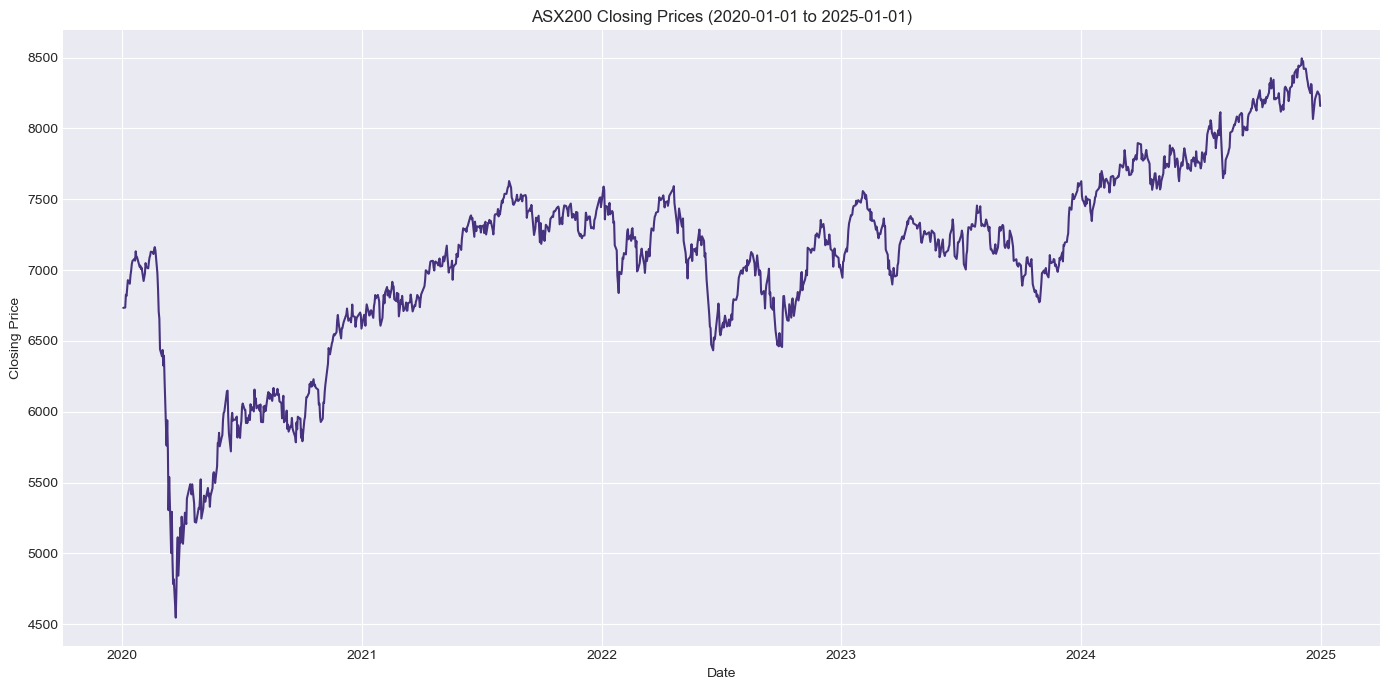

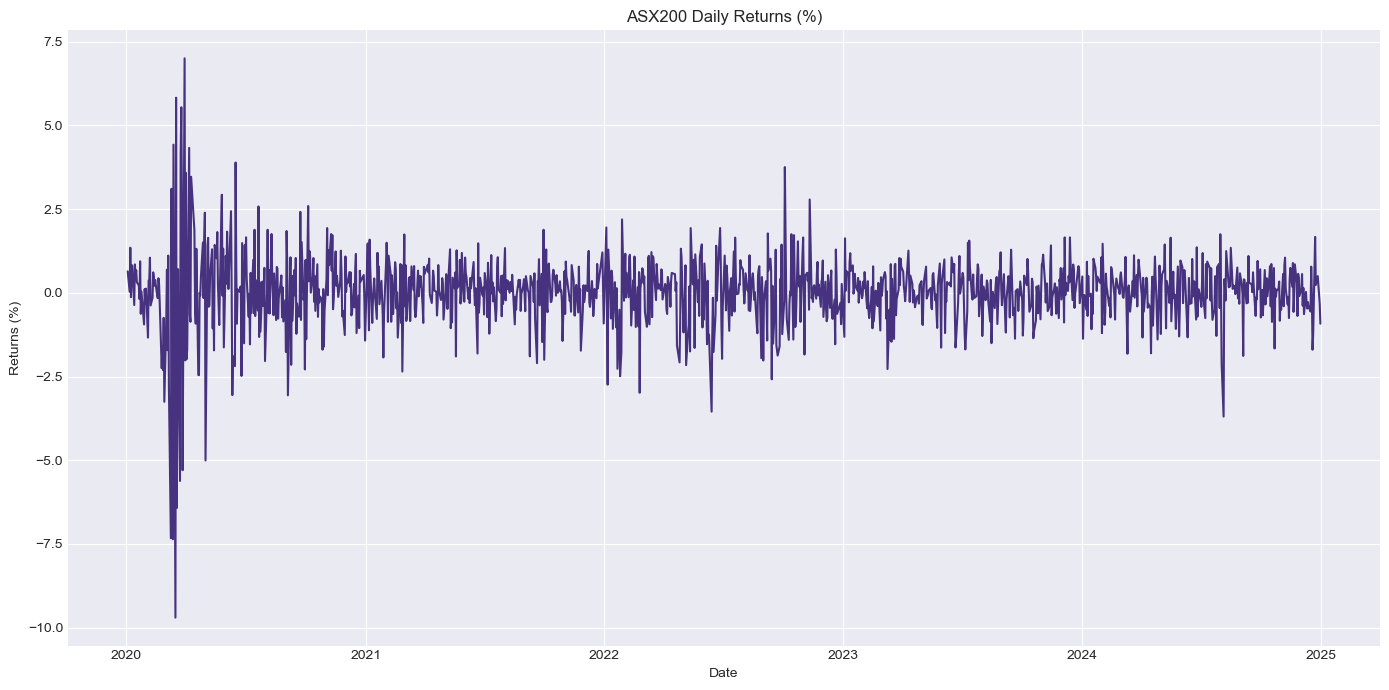

In [69]:
# 3. Visualize the time series
plt.figure(figsize=(14, 7))
plt.plot(close_series)
plt.title('ASX200 Closing Prices (2020-01-01 to 2025-01-01)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize returns
plt.figure(figsize=(14, 7))
plt.plot(data['Returns'])
plt.title('ASX200 Daily Returns (%)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

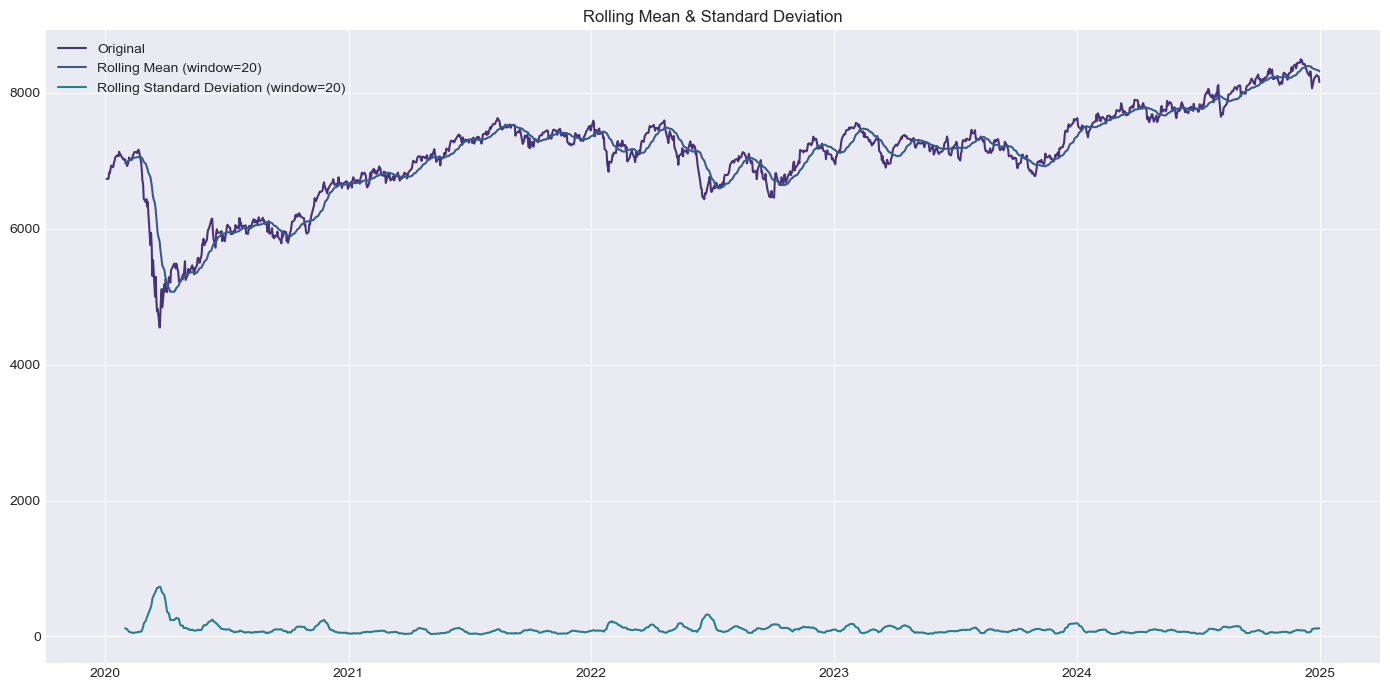

In [70]:
# Rolling statistics (window of 20 days)
window = 20
rolling_mean = close_series.rolling(window=window).mean()
rolling_std = close_series.rolling(window=window).std()
# Plot rolling statistics
plt.figure(figsize=(14, 7))
plt.title('Rolling Mean & Standard Deviation')
plt.plot(close_series, label='Original')
plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')
plt.plot(rolling_std, label=f'Rolling Standard Deviation (window={window})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
print("-------1---------------1----------------1----------------1--------------1--------------1")
print(close_series)
# Augmented Dickey-Fuller test
print('\nAugmented Dickey-Fuller Test Results:')
adf_result = adfuller(close_series.dropna())

print("-------2---------------2----------------2----------------2--------------2--------------2")

print(adf_result)

adf_output = pd.Series(
    adf_result[0:4],
    index=['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
)


for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print(adf_output)

-------1---------------1----------------1----------------1--------------1--------------1
Ticker            ^AXJO
Date                   
2020-01-03  6733.500000
2020-01-06  6735.700195
2020-01-07  6826.399902
2020-01-08  6817.600098
2020-01-09  6874.200195
...                 ...
2024-12-23  8201.599609
2024-12-24  8220.900391
2024-12-27  8261.799805
2024-12-30  8235.000000
2024-12-31  8159.100098

[1265 rows x 1 columns]

Augmented Dickey-Fuller Test Results:
-------2---------------2----------------2----------------2--------------2--------------2
(-1.6707705576945737, 0.44623177565499816, 13, 1251, {'1%': -3.4355880246374304, '5%': -2.8638531175675896, '10%': -2.568001531098063}, 14034.49555138641)
ADF Statistic             -1.670771
p-value                    0.446232
# Lags Used               13.000000
# Observations Used     1251.000000
Critical Value (1%)       -3.435588
Critical Value (5%)       -2.863853
Critical Value (10%)      -2.568002
dtype: float64


In [72]:
# Check if stationary
if adf_result[1] <= 0.05:
    print("The series is stationary (Reject H0)")
    is_stationary = True
else:
    print("The series is non-stationary (Fail to reject H0)")
    is_stationary = False


The series is non-stationary (Fail to reject H0)



Applying first differencing to make series stationary...


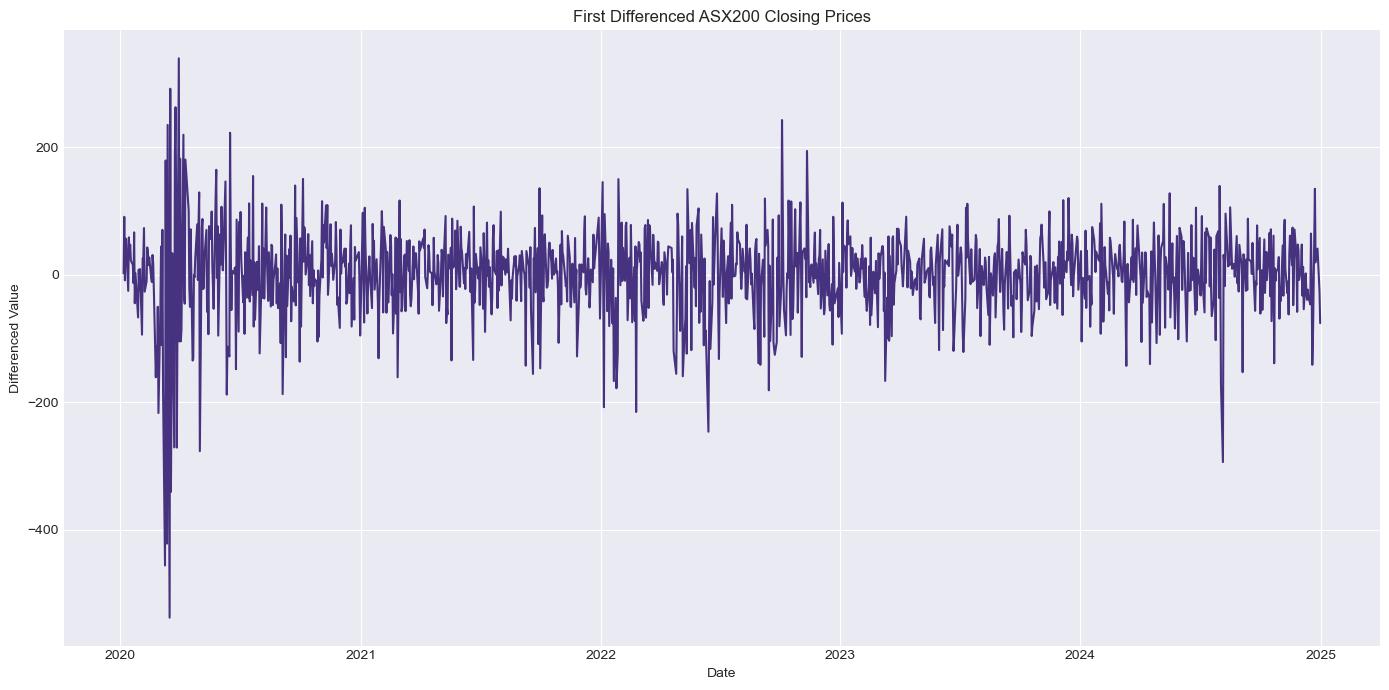


Augmented Dickey-Fuller Test Results (After First Differencing):
ADF Statistic          -9.393679e+00
p-value                 6.459410e-16
# Lags Used             1.200000e+01
# Observations Used     1.251000e+03
Critical Value (1%)    -3.435588e+00
Critical Value (5%)    -2.863853e+00
Critical Value (10%)   -2.568002e+00
dtype: float64
The differenced series is stationary (Reject H0)


In [73]:
# 5. Apply differencing if needed
if not is_stationary:
    print("\nApplying first differencing to make series stationary...")
    differenced_series = close_series.diff().dropna()
    
    # Visualize differenced series
    plt.figure(figsize=(14, 7))
    plt.plot(differenced_series)
    plt.title('First Differenced ASX200 Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Differenced Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Augmented Dickey-Fuller test on differenced series
    print('\nAugmented Dickey-Fuller Test Results (After First Differencing):')
    adf_result_diff = adfuller(differenced_series.dropna())
    
    adf_output_diff = pd.Series(
        adf_result_diff[0:4],
        index=['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    )
    
    for key, value in adf_result_diff[4].items():
        adf_output_diff[f'Critical Value ({key})'] = value
    
    print(adf_output_diff)
    # Check if differenced series is stationary
    if adf_result_diff[1] <= 0.05:
        print("The differenced series is stationary (Reject H0)")
        d_value = 1  # Set differencing order to 1
    else:
        print("The differenced series is still non-stationary, applying second differencing...")
        second_differenced_series = differenced_series.diff().dropna()
        
        # Augmented Dickey-Fuller test on second differenced series
        adf_result_diff2 = adfuller(second_differenced_series.dropna())
        
        if adf_result_diff2[1] <= 0.05:
            print("The second differenced series is stationary (Reject H0)")
            d_value = 2  # Set differencing order to 2
        else:
            print("Warning: Series still not stationary after second differencing")
            d_value = 1  # Default to 1 if issues arise
else:
    d_value = 0
    differenced_series = close_series


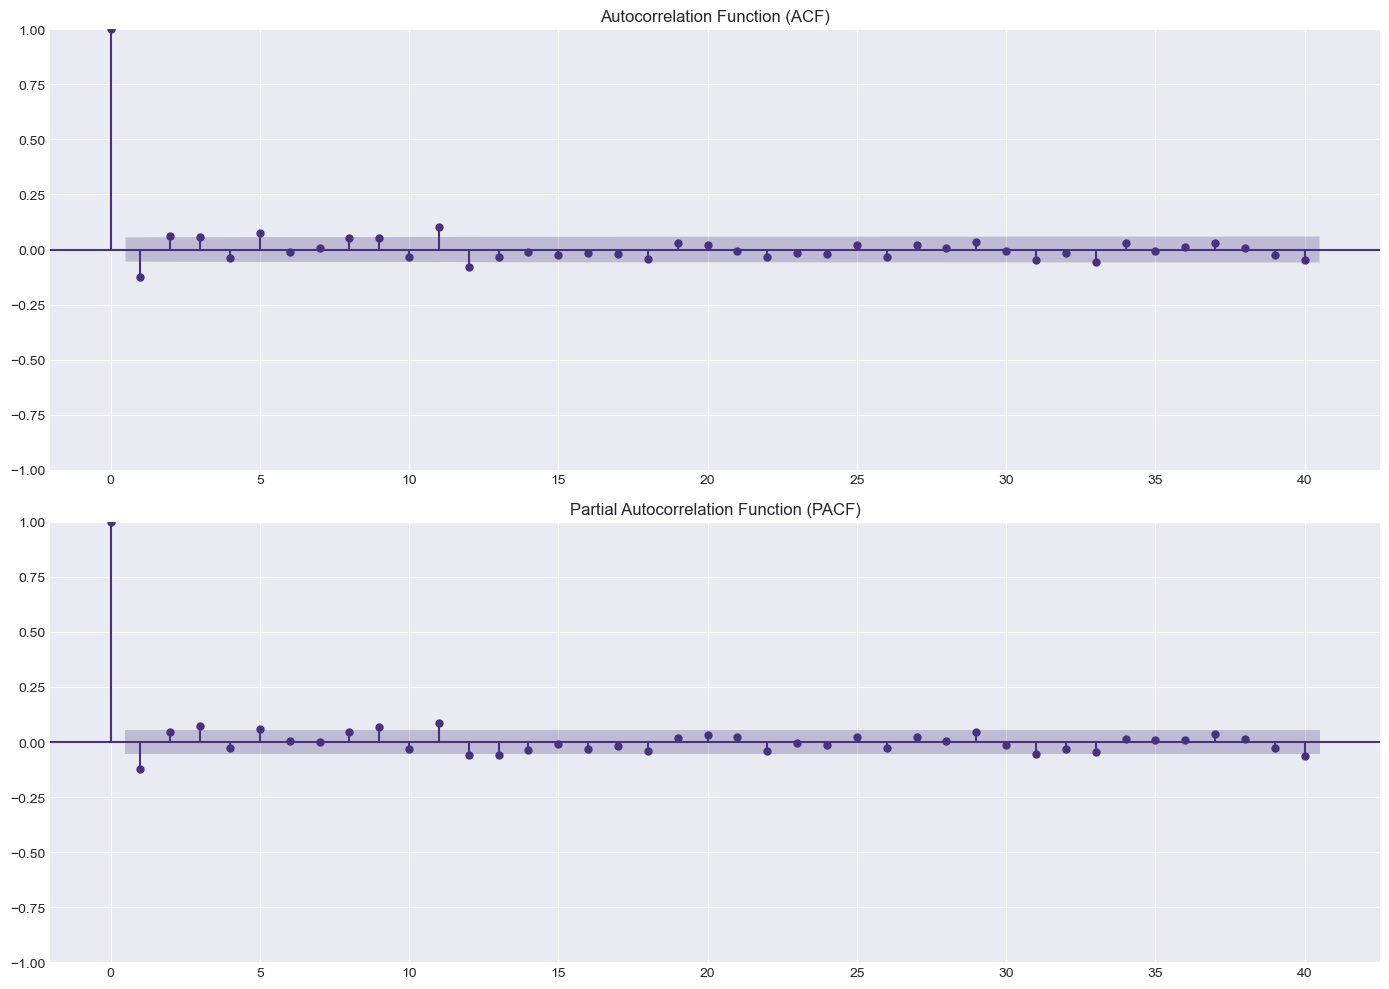

In [74]:
# 6. Plot ACF and PACF to determine model parameters
lags = 40

plt.figure(figsize=(14, 10))

# ACF
plt.subplot(211)
plot_acf(differenced_series, lags=lags, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(212)
plot_pacf(differenced_series, lags=lags, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [75]:
# Based on ACF/PACF, determine p, d, q values
# This is a simplified approach - you may need to adjust based on your interpretation
print("\nBased on ACF/PACF plots:")
print(f"Suggested d value: {d_value}")
print("Examine the plots to determine p and q values")
print("Typically, cut-off in PACF suggests AR order (p)")
print("Typically, cut-off in ACF suggests MA order (q)")


Based on ACF/PACF plots:
Suggested d value: 1
Examine the plots to determine p and q values
Typically, cut-off in PACF suggests AR order (p)
Typically, cut-off in ACF suggests MA order (q)


In [76]:
# 7. Train-test split
train_size = int(len(close_series) * 0.8)
train = close_series[:train_size]
test = close_series[train_size:]

print(f"\nTrain set size: {train.shape[0]} observations")
print(f"Test set size: {test.shape[0]} observations")

print("-------3---------------3----------------3----------------3--------------3--------------3")
print(train)
print("-------4---------------4----------------4----------------4--------------4--------------4")
print(test)


Train set size: 1012 observations
Test set size: 253 observations
-------3---------------3----------------3----------------3--------------3--------------3
Ticker            ^AXJO
Date                   
2020-01-03  6733.500000
2020-01-06  6735.700195
2020-01-07  6826.399902
2020-01-08  6817.600098
2020-01-09  6874.200195
...                 ...
2023-12-22  7501.600098
2023-12-27  7561.200195
2023-12-28  7614.299805
2023-12-29  7590.799805
2024-01-02  7627.799805

[1012 rows x 1 columns]
-------4---------------4----------------4----------------4--------------4--------------4
Ticker            ^AXJO
Date                   
2024-01-03  7523.200195
2024-01-04  7494.100098
2024-01-05  7489.100098
2024-01-08  7451.500000
2024-01-09  7520.500000
...                 ...
2024-12-23  8201.599609
2024-12-24  8220.900391
2024-12-27  8261.799805
2024-12-30  8235.000000
2024-12-31  8159.100098

[253 rows x 1 columns]


In [77]:
# 8. Build and evaluate models
models_results = {}

# 8.1 ARIMA model (1,1,1)
print("\nBuilding ARIMA(1,1,1) model...")
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Print model summary
print(arima_fit.summary())



Building ARIMA(1,1,1) model...
                               SARIMAX Results                                
Dep. Variable:                  ^AXJO   No. Observations:                 1012
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5756.315
Date:                Wed, 09 Apr 2025   AIC                          11518.630
Time:                        15:53:16   BIC                          11533.386
Sample:                             0   HQIC                         11524.235
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3242      0.120     -2.710      0.007      -0.559      -0.090
ma.L1          0.1912      0.132      1.451      0.147      -0.067       0.449
sigma2      5180.769

ARIMA(1,1,1) Evaluation Metrics:
RMSE: 396.3071
MAE: 311.6088
MAPE: 3.8428%


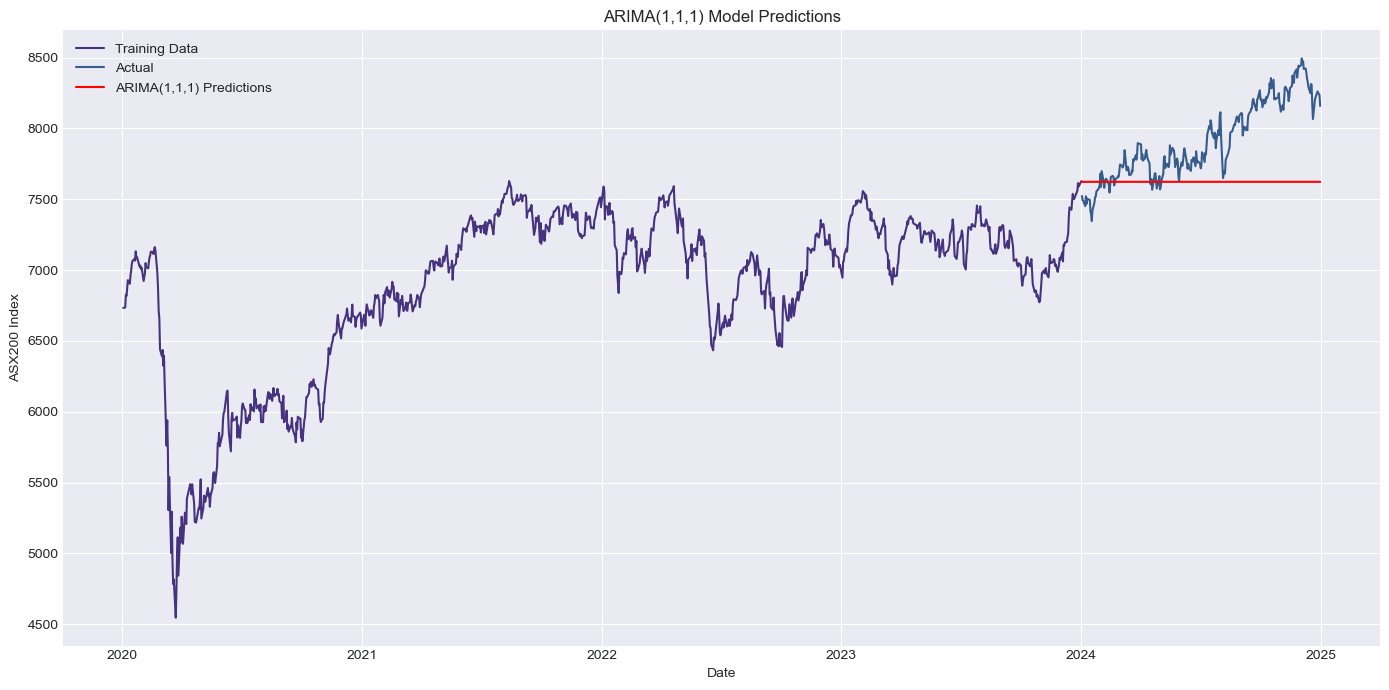

In [78]:
# Make predictions
arima_preds = arima_fit.forecast(steps=len(test))

# Evaluate model
arima_rmse = np.sqrt(mean_squared_error(test, arima_preds))
arima_mae = mean_absolute_error(test, arima_preds)
arima_mape = mean_absolute_percentage_error(test, arima_preds) * 100

print(f"ARIMA(1,1,1) Evaluation Metrics:")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"MAPE: {arima_mape:.4f}%")

# Store metrics
models_results['ARIMA(1,1,1)'] = (arima_rmse, arima_mae, arima_mape)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_preds, label='ARIMA(1,1,1) Predictions', color='red')
plt.title('ARIMA(1,1,1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('ASX200 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Building ARIMA(2,1,2) model...
                               SARIMAX Results                                
Dep. Variable:                  ^AXJO   No. Observations:                 1012
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5750.375
Date:                Wed, 09 Apr 2025   AIC                          11510.751
Time:                        15:53:17   BIC                          11535.344
Sample:                             0   HQIC                         11520.093
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6589      0.099      6.640      0.000       0.464       0.853
ar.L2          0.1240      0.101      1.223      0.221      -0.075       0.323
ma.L1         -0.792

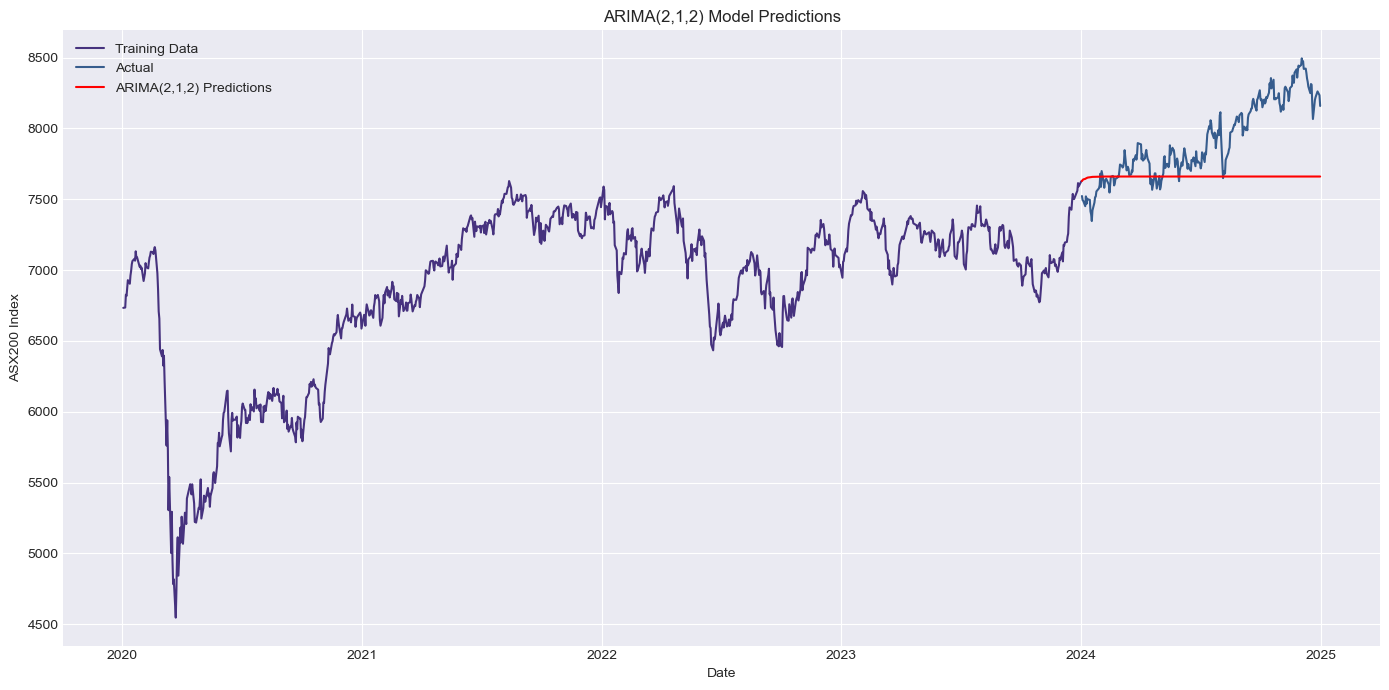

In [79]:
# 8.2 ARIMA model (2,1,2)
print("\nBuilding ARIMA(2,1,2) model...")
arima_model2 = ARIMA(train, order=(2,1,2))
arima_fit2 = arima_model2.fit()

# Print model summary
print(arima_fit2.summary())

# Make predictions
arima_preds2 = arima_fit2.forecast(steps=len(test))

# Evaluate model
arima_rmse2 = np.sqrt(mean_squared_error(test, arima_preds2))
arima_mae2 = mean_absolute_error(test, arima_preds2)
arima_mape2 = mean_absolute_percentage_error(test, arima_preds2) * 100

print(f"ARIMA(2,1,2) Evaluation Metrics:")
print(f"RMSE: {arima_rmse2:.4f}")
print(f"MAE: {arima_mae2:.4f}")
print(f"MAPE: {arima_mape2:.4f}%")

# Store metrics
models_results['ARIMA(2,1,2)'] = (arima_rmse2, arima_mae2, arima_mape2)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_preds2, label='ARIMA(2,1,2) Predictions', color='red')
plt.title('ARIMA(2,1,2) Model Predictions')
plt.xlabel('Date')
plt.ylabel('ASX200 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Building SARIMA(1,1,1)(1,1,1,5) model...
                                     SARIMAX Results                                     
Dep. Variable:                             ^AXJO   No. Observations:                 1012
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -5736.057
Date:                           Wed, 09 Apr 2025   AIC                          11482.115
Time:                                   15:53:18   BIC                          11506.684
Sample:                                        0   HQIC                         11491.450
                                          - 1012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3379      0.128     -2.643      0.008      -0.588      -0.087
m

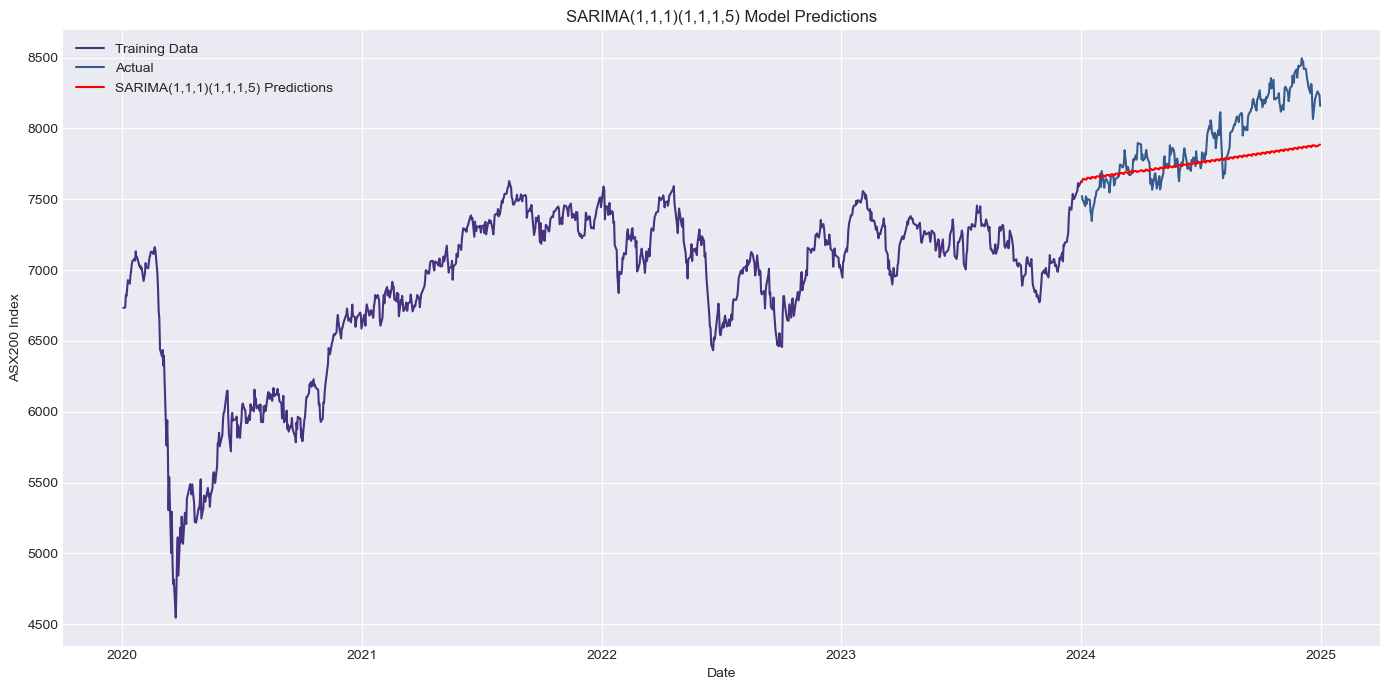

In [80]:
# 8.3 SARIMA model with weekly seasonality (5 trading days)
print("\nBuilding SARIMA(1,1,1)(1,1,1,5) model...")
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,5))
sarima_fit = sarima_model.fit(disp=False)

# Print model summary
print(sarima_fit.summary())

# Make predictions
sarima_preds = sarima_fit.forecast(steps=len(test))

# Evaluate model
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_preds))
sarima_mae = mean_absolute_error(test, sarima_preds)
sarima_mape = mean_absolute_percentage_error(test, sarima_preds) * 100

print(f"SARIMA(1,1,1)(1,1,1,5) Evaluation Metrics:")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAE: {sarima_mae:.4f}")
print(f"MAPE: {sarima_mape:.4f}%")

# Store metrics
models_results['SARIMA(1,1,1)(1,1,1,5)'] = (sarima_rmse, sarima_mae, sarima_mape)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_preds, label='SARIMA(1,1,1)(1,1,1,5) Predictions', color='red')
plt.title('SARIMA(1,1,1)(1,1,1,5) Model Predictions')
plt.xlabel('Date')
plt.ylabel('ASX200 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Building SARIMA(1,1,1)(1,1,1,20) model...
                                     SARIMAX Results                                      
Dep. Variable:                              ^AXJO   No. Observations:                 1012
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 20)   Log Likelihood               -5679.021
Date:                            Wed, 09 Apr 2025   AIC                          11368.043
Time:                                    15:53:22   BIC                          11392.537
Sample:                                         0   HQIC                         11377.356
                                           - 1012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3241      0.144     -2.247      0.025      -0.607     

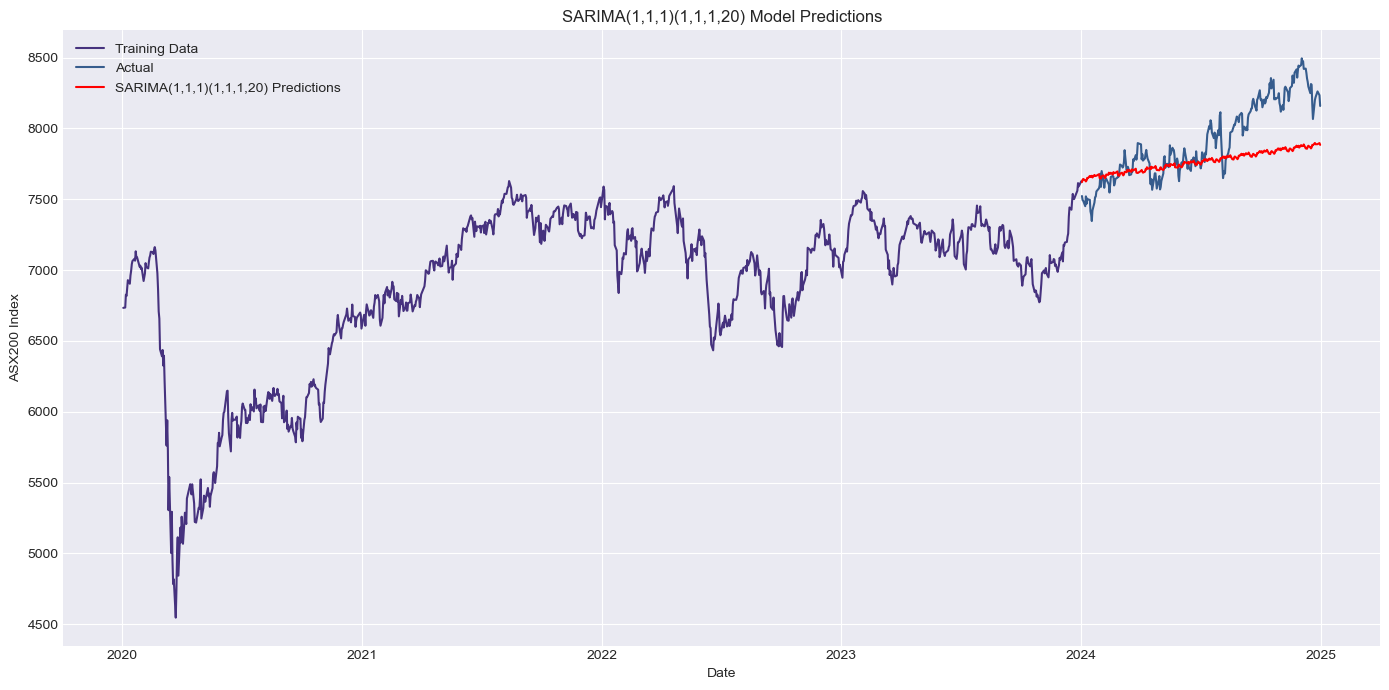

In [81]:
# 8.4 SARIMA model with monthly seasonality (20 trading days)
print("\nBuilding SARIMA(1,1,1)(1,1,1,20) model...")
sarima_model2 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,20))
sarima_fit2 = sarima_model2.fit(disp=False)

# Print model summary
print(sarima_fit2.summary())

# Make predictions
sarima_preds2 = sarima_fit2.forecast(steps=len(test))

# Evaluate model
sarima_rmse2 = np.sqrt(mean_squared_error(test, sarima_preds2))
sarima_mae2 = mean_absolute_error(test, sarima_preds2)
sarima_mape2 = mean_absolute_percentage_error(test, sarima_preds2) * 100

print(f"SARIMA(1,1,1)(1,1,1,20) Evaluation Metrics:")
print(f"RMSE: {sarima_rmse2:.4f}")
print(f"MAE: {sarima_mae2:.4f}")
print(f"MAPE: {sarima_mape2:.4f}%")

# Store metrics
models_results['SARIMA(1,1,1)(1,1,1,20)'] = (sarima_rmse2, sarima_mae2, sarima_mape2)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_preds2, label='SARIMA(1,1,1)(1,1,1,20) Predictions', color='red')
plt.title('SARIMA(1,1,1)(1,1,1,20) Model Predictions')
plt.xlabel('Date')
plt.ylabel('ASX200 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# Extract model names and metrics
model_names = list(models_results.keys())
rmse_values = [metrics[0] for metrics in models_results.values()]
mae_values = [metrics[1] for metrics in models_results.values()]
mape_values = [metrics[2] for metrics in models_results.values()]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE (%)': mape_values
})

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')

print(comparison_df)


                     Model        RMSE         MAE  MAPE (%)
3  SARIMA(1,1,1)(1,1,1,20)  255.727667  195.578142  2.414847
2   SARIMA(1,1,1)(1,1,1,5)  257.495969  197.202804  2.434363
1             ARIMA(2,1,2)  369.766427  285.437480  3.518205
0             ARIMA(1,1,1)  396.307062  311.608838  3.842836


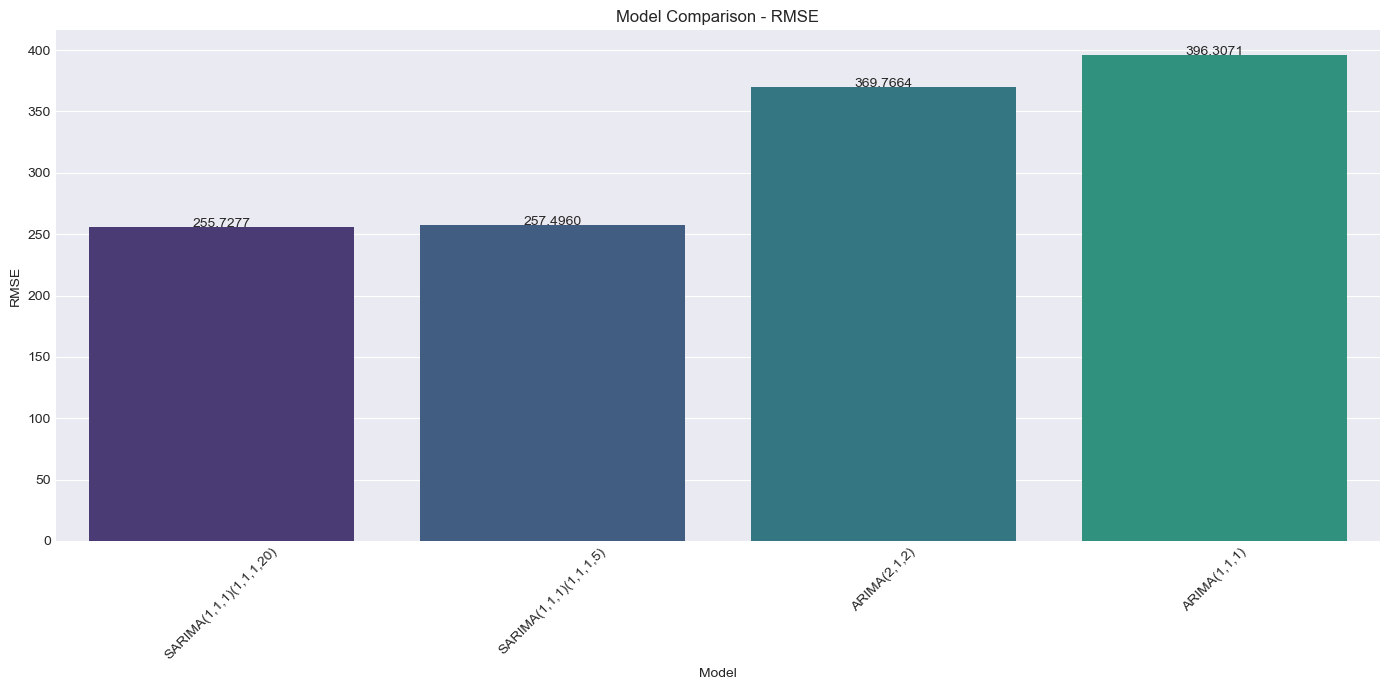

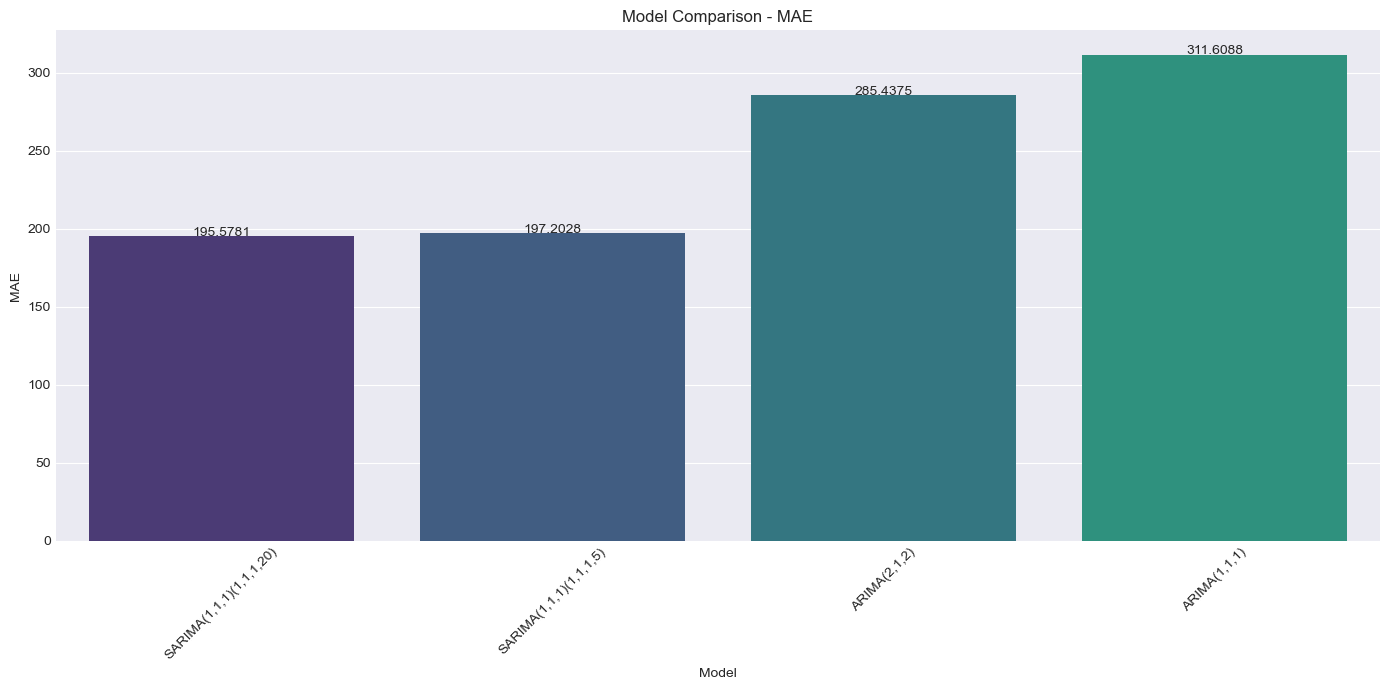

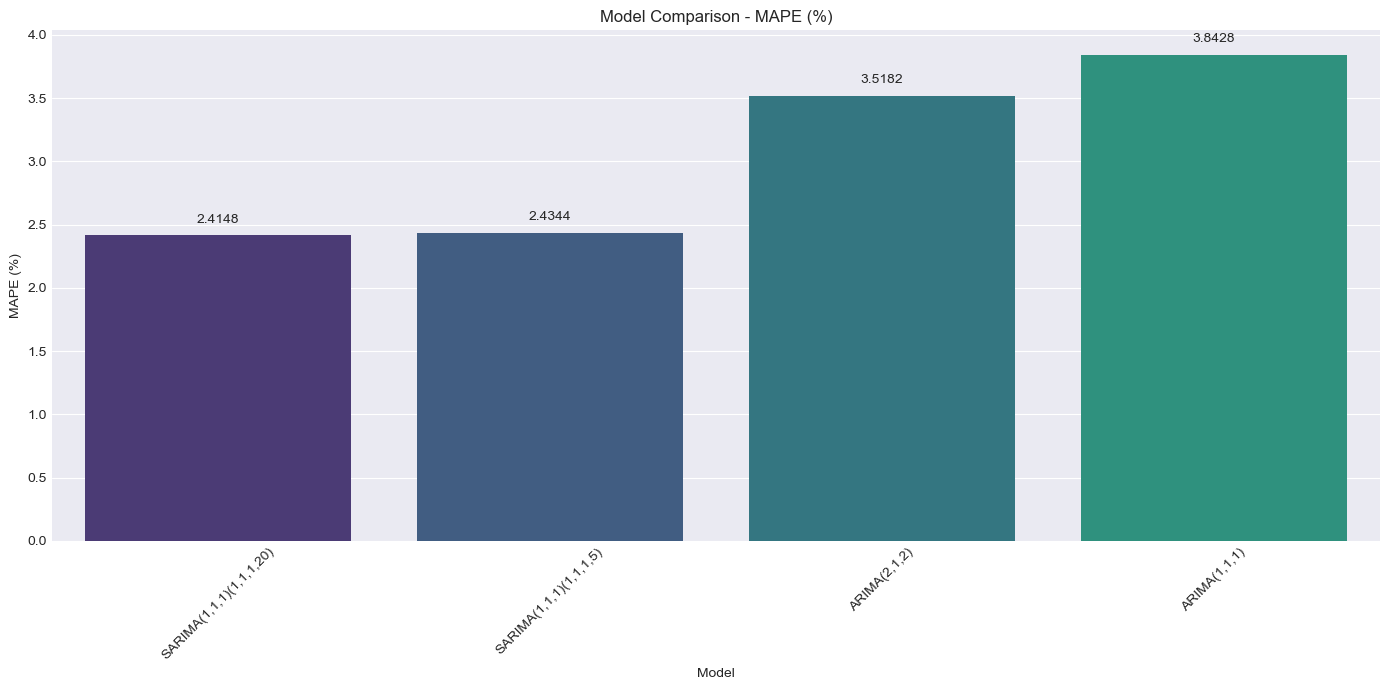

In [83]:
# Plot comparison
metrics = ['RMSE', 'MAE', 'MAPE (%)']

for metric in metrics:
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add values on top of bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.1, f'{v:.4f}', ha='center')
    
    plt.show()



Best performing model based on RMSE: SARIMA(1,1,1)(1,1,1,20)


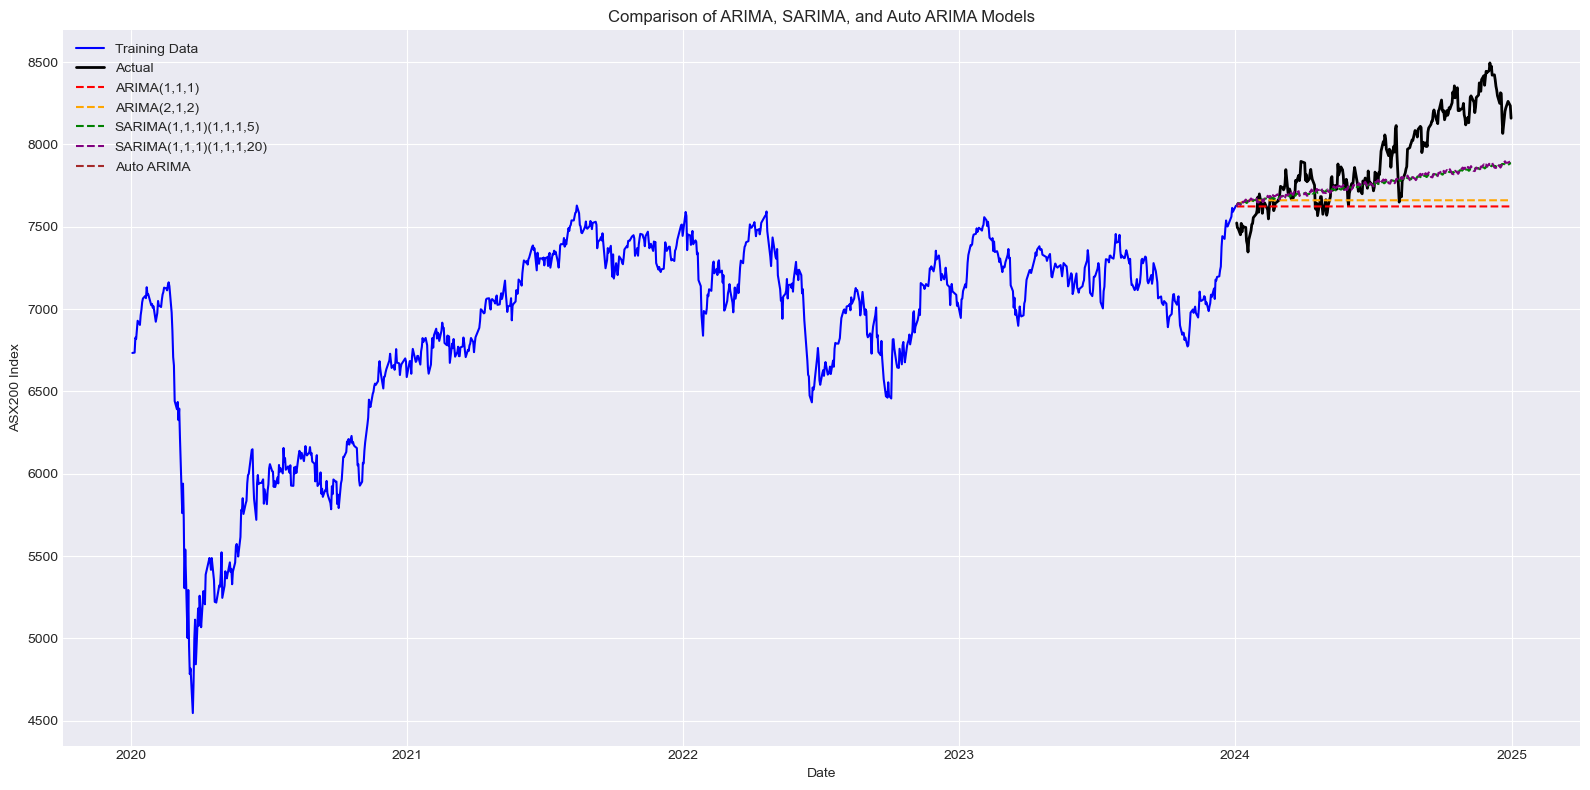

In [84]:
# Identify best model
best_model = comparison_df.iloc[0]['Model']
print(f"\nBest performing model based on RMSE: {best_model}")

# 10. Plot all predictions together
plt.figure(figsize=(16, 8))

# Plot data and predictions
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, arima_preds, label='ARIMA(1,1,1)', color='red', linestyle='--')
plt.plot(test.index, arima_preds2, label='ARIMA(2,1,2)', color='orange', linestyle='--')
plt.plot(test.index, sarima_preds, label='SARIMA(1,1,1)(1,1,1,5)', color='green', linestyle='--')
plt.plot(test.index, sarima_preds2, label='SARIMA(1,1,1)(1,1,1,20)', color='purple', linestyle='--')
plt.plot(test.index, auto_arima_preds, label='Auto ARIMA', color='brown', linestyle='--')

plt.title('Comparison of ARIMA, SARIMA, and Auto ARIMA Models')
plt.xlabel('Date')
plt.ylabel('ASX200 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()